In [71]:
# import test_tensor_2d as tt ttbd
import quimb.tensor as qtn
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import denseQubits as dq
import hubbardJWT as hjw
import stabilizers as stab
import qubitNetworks as beeky
from itertools import product
import autoray
import scipy.sparse as sparse
import functools


In [394]:
reload(dq)
sql = dq.SpinlessDense()
# sql.t_make_stabilizers()

In [550]:
reload(dq)
reload(hjw)

##Testing params
T_PARAM=1
V_PARAM=2
MU_PARAM=0
LX, LY = 2, 3


### Analytical Hubbard Hamiltonian
hub = hjw.HubbardSpinless(Lx=LX, Ly=LY)
hub.build_spinless_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
Hexact = hub._Ham.copy()
gex, gsx = qu.eigh(Hexact)
print(f'Exact: {gex[0:3]}')

# nx = hub.state_occs(state=gsx[:,0])
# print(nx,end='\n\n')


### Qubit lattice Hamiltonian
sql = dq.SpinlessDense(Lx=LX,Ly=LY)
sql.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
simHam = sql.ham_sim()
sens, seigst = qu.eigh(simHam)
print(f'Nonstable: {sens[0:3]}')

sql.make_stabilizer()
codeHam = sql.ham_code()
rens, reigst = qu.eigh(codeHam)
print(f'Stable: {rens[0:3]}')

# print(sql.state_local_occs(k=None, qstate=Uplus@reigst[:,0]))

Exact: [-3.06118188 -2.41421356 -2.27945232]
Nonstable: [-3.18711224 -3.06118188 -2.41421356]
Stable: [-3.06118188 -2.41421356 -2.27945232]


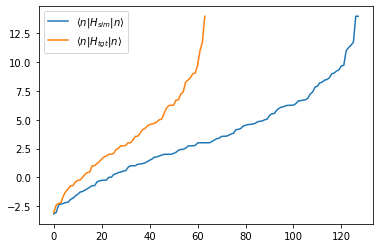

In [551]:
plt.plot(sens, label=r'$\langle n|H_{sim}|n\rangle$')
plt.plot(rens, label=r'$\langle n|H_{tgt}|n\rangle$')
plt.legend()

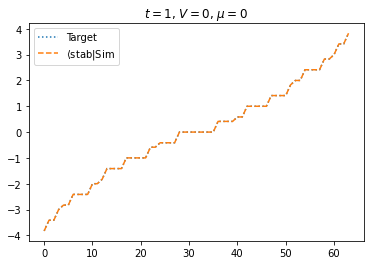

In [499]:
plt.plot(gex, ':', label=r'Target') #exact Hubbard energies
plt.plot(rens, '--',label=r'$\langle$stab$|$Sim')

plt.title(r'$t={}$, $V={}$, $\mu={}$'.format(T_PARAM,V_PARAM,MU_PARAM))
plt.legend()

In [500]:
for k in range(64):
    A = hub.state_occs(qu.basis_vec(i=k, dim=64))
    B = sql.state_local_occs(qstate=Uplus[:,k])
    assert np.allclose(A,B) #may not hold when degeneracies
sql.one_qubit_dm(Uplus@reigst[:,0], i=5)

[[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

In [400]:
# reload(stab)
reload(dq)
# qlat = dq.SpinlessDense(Lx=3, Ly=3)
# Uplus = stab.two_qubit_codespace(qlat)
# Uplus.shape
# qlat = dq.SpinlessDense(Lx=4,Ly=3)
# Up3 = stab.three_qubit_stabilizer(qlat)
reload(hjw)
# reload(denseSpinhalf)

hubhalf = hjw.HubbardSpinhalfExact(Lx=1, Ly=4, t=1.0, U=0)
hubhalf.build_spinhalf_ham()
h2ex = hubhalf.HamExact()

dse = dq.DenseSpinhalf(Lx=1,Ly=4)
dse.make_simulator_ham(t=1.0, U=0)
H2 = dse.ham_sim()

np.array_equal(H2, h2ex)# np.array_equal(H2, h2ex)

True

In [126]:
reload(beeky)
reload(dq)

T_PARAM=1.0
V_PARAM=1.26
MU_PARAM=0.9

# qlat = dq.SpinlessDense(Lx=2,Ly=3)
# qlat.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
# simHam = qlat.ham_sim()
# sens, seigst = qu.eigh(simHam)
print(f'Nonstable: {sens[0:3]}')

# qlat.make_stabilizer()
# codeHam = qlat.ham_code()
# rens, reigst = qu.eigh(codeHam)
print(f'Stable: {rens[0:3]}')

# HSIM = beeky.SpinlessFermiSim(qlat, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
# HSTAB = beeky.HamStab(qlat)
# HMASTER = beeky.MasterHam(HSIM, HSTAB)

tensors = beeky.make_random_net(qlat)
net1 = beeky.QubitEncodeNet(qlat, psi=tensors.copy())
net2 = beeky.QubitEncodeNet(qlat, psi=tensors.copy())

psi0 = net1.net_to_dense()
print('<H(0)>:  ',net1.compute_ham_expec(HSIM, normalize=True))


Nonstable: [-5.53274124 -5.37051838 -5.12289199]
Stable: [-5.37051838 -4.9630457  -4.69530491]
<H(0)>:   (-0.10317235242738462+3.947190690367742e-17j)


In [127]:
reload(beeky)
comp_fns = {'stab' : functools.partial(beeky.compute_encnet_ham_expec, ham = HSTAB),
            'norm':beeky.compute_encnet_normsquared,
            'sim': functools.partial(beeky.compute_encnet_ham_expec, ham=HSIM)  }

tebd = beeky.iTimeTEBD(net1, ham=HMASTER, compute_every=10,compute_extra_fns=comp_fns)

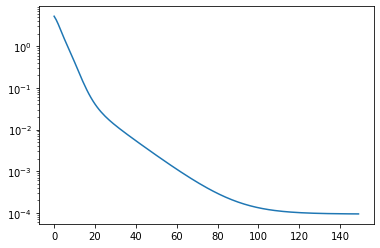

In [139]:
# tebd.evolve(500)
plt.semilogy(tebd.get_final_data('Esim') - rens[0])
# plt.semilogy(tebd.get_final_data('Estab')+1)




n=1450, tau=0.01, energy~-5.532419: 100%|██████████| 500/500 [00:02<00:00, 191.43it/s]


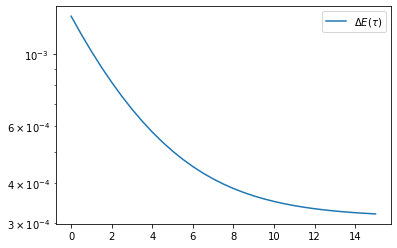

In [29]:
tebd1 = beeky.iTimeTEBD(net1, HSIM, compute_every=50)
tebd2 = beeky.iTimeTEBD(net2, HMASTER, compute_every=50)
tebd.evolve(500)
plt.semilogy(tebd.tau*np.array(tebd.iters), np.array(tebd.energies)-ges[0],label=r'$\Delta E(\tau)$')
plt.legend()

In [30]:
np.abs(qenet.dense_inner_product(gst[:,0]).item())

0.9999210176376412

In [33]:
reload(beeky)
reload(dq)
T_PARAM = 1.4
U_PARAM = 0.9


# dse = dq.DenseSpinhalf(Lx=1, Ly=4)
# dse.make_simulator_ham(t=T_PARAM, U=U_PARAM)
# Hdense = dse.ham_sim()
# ens, est = qu.eigh(Hdense)
# gstate = qu.qu(est[:,0])
print(ens[0:3])

# newlat = dq.DenseSpinhalf(Lx=1, Ly=4)

# newHam = beeky.SpinhalfHubbardSim(newlat, t=T_PARAM, U=U_PARAM)

newnet = beeky.QubitEncodeNet.rand_network(newlat, phys_dim=4)

tebd2 = beeky.iTimeTEBD(newnet, newHam, compute_every=50)


[-5.42097074 -4.97826792 -4.97826792]


n=450, tau=0.01, energy~-5.398353: 100%|██████████| 500/500 [00:06<00:00, 82.34it/s]


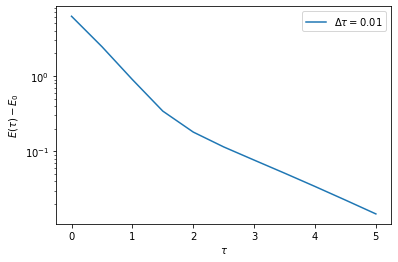

In [34]:
tebd2.evolve(steps=500)
plt.semilogy(0.01* np.array(tebd2.iters), np.array(tebd2.energies)-ens[0] , label='$\\Delta\\tau=0.01$')
plt.xlabel('$\\tau$')
plt.ylabel('$E(\\tau)-E_0$')
plt.legend()

In [56]:
reload(beeky)
reload(dq)
reload(stab)

qlat = dq.QubitCodeLattice(Lx=2, Ly=3, local_dim=2)
hstab = beeky.HamStab(qlat)
hsim = beeky.SpinlessFermiSim(qlat, t=1.0, V=0.4, mu=0)

masterham = beeky.MasterHam(Hsim=hsim, Hstab=hstab)


In [36]:
reload(stab)
reload(dq)

qlat = dq.SpinlessDense(Lx=2,Ly=3)
# code_dims = [2]*6
# sim_dims = [2]*7
U, Udag = stab.one_qubit_U_matrices(qlat, (0,1))
qlat.loop_stabilizer_data(0,1)

{'inds': (1, 2, 5, 4, 6), 'opstring': 'ZZZZX'}

In [50]:
reload(beeky)

trynet = beeky.QubitEncodeNet.rand_network(qlat, 2)
# v1 = trynet.net_to_dense(normalize=True)
v1 = U@Udag@trynet.net_to_dense()
v1 /= np.linalg.norm(v1)

projnet = beeky.QubitEncodeNet(qlat, trynet.apply_gate(G=U@Udag, where=tuple(range(7))))

v2 = projnet.net_to_dense(normalize=True)




True


In [57]:
reload(beeky)
net1 = beeky.QubitEncodeNet.rand_network(qlat, 2)
print(net1.compute_ham_expec(hstab))
v1 = net1.net_to_dense()


(-0.20250094409147257+0j)


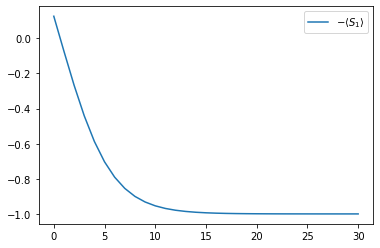

In [199]:
stebd = beeky.iTimeTEBD(net1, hstab, compute_every=10)
# stebd.evolve(steps=300)
plt.plot(stebd.energies,label=r'$-\langle S_1\rangle$')
plt.legend()


In [196]:
vtebd = net1.net_to_dense()
# net1.compute_ham_expec(hstab,True)
v1p = U@Udag@v1
v1p /= np.linalg.norm(v1p)
v1p.H @ vtebd


[[0.999996+0.j]]

In [ ]:
print(net1.compute_ham_expec(hsim, normalized=1))
print(net2.compute_ham_expec(hsim, normalized=1))